In [178]:
import numpy as np

class EM:
    p = None
    dim = None # dimension of the data space
    n_points = None # Number of data points
    n_clusters = None # Number of clusters
    pi = None # The prior probability vector of pi_j values
    X = None # the data
    
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        return
    
    def initialize(self):
        # init p, based on random X but keep all values non zero     
        self.p = np.zeros(shape = (self.dim, self.n_clusters))
        samples = np.random.randint(0, self.n_points-1, self.n_clusters)
        for i, index in enumerate(samples):
            self.p[:, i] = (self.X[index, :] + 1)/(np.sum(self.X[index, :]) + self.dim)        
        
        # the prior
        self.pi = np.ones(shape = self.n_clusters)/self.n_clusters
        return
    
    def fit(self, X):
        self.n_points = X.shape[0]
        self.dim = X.shape[1]
        self.X = X
        self.initialize();
        i = 1
        while i < 100:
            w = self.e_step()
            self.m_step(w)
            i = i + 1
            
        return
    
    def e_step(self):
        W = np.dot(self.X, np.log(self.p)) + np.log(self.pi)
        maxs = W.max(axis=1)
        W = (W.T - maxs).T
        W = (W.T - np.log(np.sum(np.exp(W), axis = 1))).T
        W = np.exp(W)
        return W
    
    def m_step(self, W):
        self.pi = np.sum(W, axis = 0)/self.n_points
        self.p = np.dot(self.X.T, W) + 1.0/self.dim
        
        colsum = np.sum(self.p, axis = 0)
        self.p = self.p/colsum
        return
        

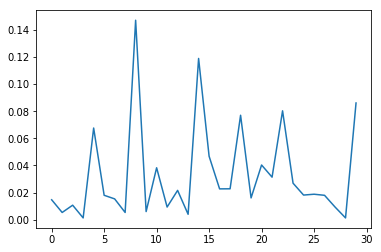

'1: model, data, network, neural, set, learning, function, algorithm, training, control'

'2: circuit, network, analog, constraint, optimization, chip, parameter, gradient, data, system'

'3: network, learning, point, algorithm, weight, unit, function, input, neural, system'

'4: network, point, kwta, code, net, decoder, codes, neural, distance, decoding'

'5: network, unit, learning, input, function, weight, output, algorithm, layer, hidden'

'6: current, input, neuron, model, channel, voltage, cell, noise, membrane, spike'

'7: network, speaker, speech, recognition, training, word, system, neural, task, set'

'8: approximation, order, distribution, information, function, entropy, data, gaussian, clustering, neural'

'9: network, model, system, learning, set, neural, input, function, unit, training'

'10: algorithm, function, loss, bound, linear, weight, problem, learning, vector, case'

'11: neuron, model, input, cell, network, visual, neural, cortex, system, cortical'

'12: eeg, component, subject, visual, signal, data, system, task, network, artifact'

'13: model, network, image, variables, graph, data, set, level, problem, function'

'14: wavelet, function, model, coefficient, basis, algorithm, signal, transform, method, data'

'15: network, learning, model, error, training, function, set, data, weight, distribution'

'16: model, data, algorithm, function, component, parameter, matrix, learning, gaussian, mixture'

'17: neuron, spike, model, firing, cell, input, synaptic, network, neural, potential'

'18: network, neural, system, processor, learning, block, data, instruction, algorithm, net'

'19: network, neural, neuron, function, input, system, model, learning, weight, circuit'

'20: network, function, bound, number, learning, dimension, neural, weight, layer, theorem'

'21: cell, model, direction, neuron, motion, input, field, system, visual, response'

'22: network, model, data, neural, set, training, function, input, algorithm, error'

'23: network, input, unit, neural, training, output, learning, recognition, system, model'

'24: learning, network, unit, model, input, neural, set, training, task, weight'

'25: signal, model, sound, system, frequency, auditory, channel, filter, input, output'

'26: learning, algorithm, examples, function, action, concept, policy, probability, number, set'

'27: model, motor, network, control, movement, speech, system, learning, trajectory, signal'

'28: problem, function, network, point, algorithm, method, neural, optimization, objective, solution'

'29: perturbation, weight, neuron, gradient, term, learning, multiple, swnp, error, parallel'

'30: algorithm, function, set, data, learning, training, error, vector, problem, classifier'

In [180]:
# Load the data
nips_data = np.loadtxt('docword.nips.txt', skiprows=3, dtype=int)
X = np.zeros(shape=(1500, 12419))

# Prepare X
for row in nips_data:
    X[row[0]-1][row[1] -1] = row[2]

em = EM(n_clusters=30)
em.fit(X)

plt.plot(em.pi)
plt.show()

words = [line.strip() for line in open('vocab.nips.txt')]

for j in range(30):
    display("{}: ".format(j+1) + ", ".join(list(np.array(words)[np.argsort(em.p[:,j])[::-1][0:10]])))
    
